## GRU

### Candidate Hidden State

对于给定的时间步$t$，假设输入是一个小批量
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本个数$n$，输入个数$d$），
上一个时间步的隐状态是
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$
（隐藏单元个数$h$）。
那么，重置门$\mathbf{R}_t \in \mathbb{R}^{n \times h}$和
更新门$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$的计算如下所示：

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

其中$\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$是偏置参数。
请注意，在求和过程中会触发广播机制
我们使用sigmoid函数将输入值转换到区间$(0, 1)$。

接下来，让我们将重置门$\mathbf{R}_t$
与常规隐状态更新机制集成，
得到在时间步$t$的*候选隐状态*（candidate hidden state）
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$。

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$

其中$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$是偏置项，
符号$\odot$是Hadamard积（按元素乘积）运算符。
在这里，我们使用tanh非线性激活函数来确保候选隐状态中的值保持在区间$(-1, 1)$中。

上式中的$\mathbf{R}_t$和$\mathbf{H}_{t-1}$
的元素相乘可以减少以往状态的影响。
每当重置门$\mathbf{R}_t$中的项接近$1$时，
我们恢复一个普通的循环神经网络。
当重置门$\mathbf{R}_t$中所有项接近$0$时，
候选隐状态是以$\mathbf{X}_t$作为输入的多层感知机的结果。
因此，任何预先存在的隐状态都会被*重置*为默认值。

### Hidden State

上述的计算结果只是候选隐状态，我们仍然需要结合更新门$\mathbf{Z}_t$的效果。
这一步确定新的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态$\mathbf{H}_{t-1}$和
新的候选状态$\tilde{\mathbf{H}}_t$。
更新门$\mathbf{Z}_t$仅需要在
$\mathbf{H}_{t-1}$和$\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
这就得出了门控循环单元的最终更新公式：

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

每当更新门$\mathbf{Z}_t$接近$1$时，模型就倾向只保留旧状态。
此时，来自$\mathbf{X}_t$的信息基本上被忽略，
从而有效地跳过了依赖链条中的时间步$t$。
相反，当$\mathbf{Z}_t$接近$0$时，
新的隐状态$\mathbf{H}_t$就会接近候选隐状态$\tilde{\mathbf{H}}_t$。
这些设计可以帮助我们处理循环神经网络中的梯度消失问题，
并更好地捕获时间步距离很长的序列的依赖关系。
例如，如果整个子序列的所有时间步的更新门都接近于$1$，
则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。

总之，门控循环单元具有以下两个显著特征：

* 重置门有助于捕获序列中的短期依赖关系；
* 更新门有助于捕获序列中的长期依赖关系。

### Achieve GRU

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
# 初始化
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xz, W_hz, b_z = three()  # 更新门
    W_xr, W_hr, b_r = three()  # 重置门
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
# 定义模型
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [5]:
# 定义门控循环单元
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, W_xz) + torch.matmul(H, W_hz) + b_z)
        R = torch.sigmoid(torch.matmul(X, W_xr) + torch.matmul(H, W_hr) + b_r)
        H_tilda = torch.tanh(torch.matmul(X, W_xh) + torch.matmul((R * H), W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 36965.5 tokens/sec on cuda:0
time travellerionscous of his fren dimensions be gateeply i thef
traveller whthed fired about the model the time traveller f


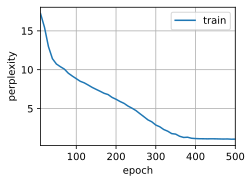

In [6]:
# 训练及预测
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                 init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### GRU Implementation by API

perplexity 1.1, 249758.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller wht a tile treve yentice tion which wryan it ho d


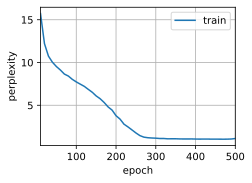

In [7]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 331829.0 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


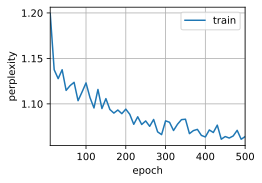

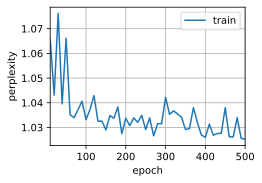

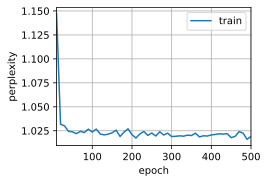

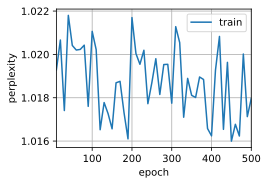

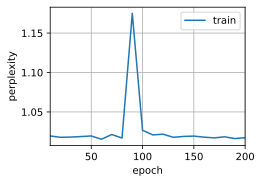

In [8]:
def test(Hyperparameters):  # [batch_size, num_steps, num_hiddens, lr, num_epochs]
    train_iter_now, vocab_now = d2l.load_data_time_machine(Hyperparameters[0], Hyperparameters[1])

    gru_layer_now = nn.GRU(len(vocab_now), Hyperparameters[2])
    net_now = d2l.RNNModel(gru_layer_now, len(vocab_now))
    net_now = model.to(device)
    d2l.train_ch8(net_now, train_iter_now, vocab_now, Hyperparameters[3], Hyperparameters[4], d2l.try_gpu())

Hyperparameters_lists = [
    [64, 35, 256, 1, 500],  # 加批量大小
    [32, 64, 256, 1, 500],  # 加时间步
    [32, 35, 512, 1, 500],  # 加隐藏单元数
    [32, 35, 256, 0.5, 500],  # 减半学习率
    [32, 35, 256, 1, 200]  # 减轮数
]

for Hyperparameters in Hyperparameters_lists:
    test(Hyperparameters)

[参考答案](https://www.cnblogs.com/AncilunKiang/p/17770811.html)

## LSTM

我们来细化一下长短期记忆网络的数学表达。
假设有$h$个隐藏单元，批量大小为$n$，输入数为$d$。
因此，输入为$\mathbf{X}_t \in \mathbb{R}^{n \times d}$，
前一时间步的隐状态为$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。
相应地，时间步$t$的门被定义如下：
输入门是$\mathbf{I}_t \in \mathbb{R}^{n \times h}$，
遗忘门是$\mathbf{F}_t \in \mathbb{R}^{n \times h}$，
输出门是$\mathbf{O}_t \in \mathbb{R}^{n \times h}$。
它们的计算方法如下：

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

其中$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$是偏置参数。

*候选记忆元*（candidate memory cell）
$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。
它的计算与上面描述的三个门的计算类似，
但是使用$\tanh$函数作为激活函数，函数的值范围为$(-1, 1)$。
下面导出在时间步$t$处的方程：

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

其中$\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$和
$\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$是偏置参数。

在门控循环单元中，有一种机制来控制输入和遗忘（或跳过）。
类似地，在长短期记忆网络中，也有两个门用于这样的目的：
输入门$\mathbf{I}_t$控制采用多少来自$\tilde{\mathbf{C}}_t$的新数据，
而遗忘门$\mathbf{F}_t$控制保留多少过去的
记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。
使用按元素乘法，得出：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

如果遗忘门始终为$1$且输入门始终为$0$，
则过去的记忆元$\mathbf{C}_{t-1}$
将随时间被保存并传递到当前时间步。
引入这种设计是为了缓解梯度消失问题，
并更好地捕获序列中的长距离依赖关系。

最后，我们需要定义如何计算隐状态
$\mathbf{H}_t \in \mathbb{R}^{n \times h}$，
这就是输出门发挥作用的地方。
在长短期记忆网络中，它仅仅是记忆元的$\tanh$的门控版本。
这就确保了$\mathbf{H}_t$的值始终在区间$(-1, 1)$内：

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

只要输出门接近$1$，我们就能够有效地将所有记忆信息传递给预测部分，
而对于输出门接近$0$，我们只保留记忆元内的所有信息，而不需要更新隐状态。


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [10]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [16]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, 
              W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

In [20]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [13]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, 
     W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)  # 候选神经元
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.1, 29570.8 tokens/sec on cuda:0
time traveller comerure the erechtent thefoll was four dimension
travelleryou can show black is white by argument said filby


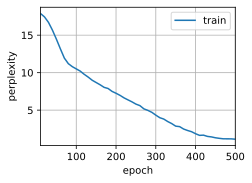

In [21]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 293617.3 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


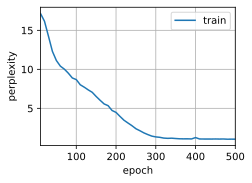

In [19]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 4.4, 347675.7 tokens/sec on cuda:0
time traveller the thing the time traveller the thing the time t
traveller the thing the time traveller the thing the time t


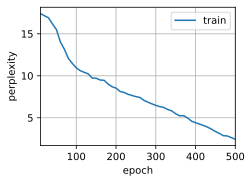

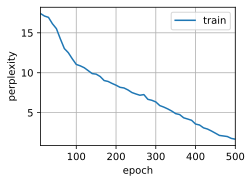

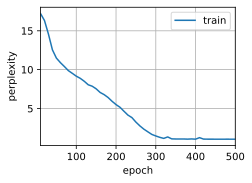

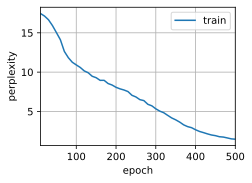

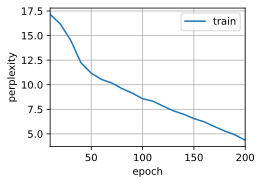

In [23]:
def test(Hyperparameters):  # [batch_size, num_steps, num_hiddens, lr, num_epochs]
    train_iter_now, vocab_now = d2l.load_data_time_machine(Hyperparameters[0], Hyperparameters[1])

    lstm_layer_now = nn.LSTM(len(vocab_now), Hyperparameters[2])
    net_now = d2l.RNNModel(lstm_layer_now, len(vocab_now))
    net_now = net_now.to(device)
    d2l.train_ch8(net_now, train_iter_now, vocab_now, Hyperparameters[3], Hyperparameters[4], d2l.try_gpu())

Hyperparameters_lists = [
    [64, 35, 256, 1, 500],  # 加批量大小
    [32, 64, 256, 1, 500],  # 加时间步
    [32, 35, 512, 1, 500],  # 加隐藏单元数
    [32, 35, 256, 0.5, 500],  # 减半学习率
    [32, 35, 256, 1, 200]  # 减轮数
]

for Hyperparameters in Hyperparameters_lists:
    test(Hyperparameters)

### Word Prediction

困惑度 1.6, 79692.6 词元/秒 cuda:0
the time traveller i said to argue so so my mind was attracted by the pretty little how what s a game said the fire the psychologist was to have the warm s telling anecdotes at hettie from his expression bars dusty about me to with other said the sleeves did who wait 


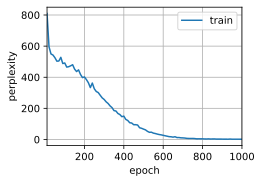

In [4]:
def predict_ch8_word(prefix, num_preds, net, vocab, device):  # 词预测
    """在prefix后面生成新词语"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]  # 调用 vocab 类的 __getitem__ 方法
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))  # 把预测结果（结果的最后一个）作为下一个的输入
    for y in prefix[1:]:  # 预热期 把前缀先载进模型
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测 num_preds 步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))  # 优雅
    return ''.join([vocab.idx_to_token[i] + ' ' for i in outputs])  # 加个空格分隔各词

def train_ch8_word(net, train_iter, vocab, lr, num_epochs, device,  # 词训练
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8_word(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            # print(predict(['time', 'traveller']))
            animator.add(epoch + 1, [ppl])  # 使用 word 而非 char
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    # print(predict(['time', 'traveller']))
    print(predict(['the', 'time', 'traveller']))

class SeqDataLoader_word:  # 词加载器
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        lines = d2l.read_time_machine()
        tokens = d2l.tokenize(lines, token='word')  # 使用 word 而非 char
        self.vocab_word = d2l.Vocab(tokens)  # 构建 word 词表
        self.corpus_word = [self.vocab_word[token] for line in tokens for token in line]
        if max_tokens > 0:
            self.corpus_word = self.corpus_word[:max_tokens]
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus_word, self.batch_size, self.num_steps)

train_iter_word = SeqDataLoader_word(
        64, 35, False, 10000)
vocab_word = train_iter_word.vocab_word

lstm_layer_word = nn.LSTM(len(vocab_word), 256)
model_word = d2l.RNNModel(lstm_layer_word, len(vocab_word))
model_word = model_word.to(d2l.try_gpu())
train_ch8_word(model_word, train_iter_word, vocab_word, 1.5, 1000, d2l.try_gpu())


### Comparision

In [5]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

num_inputs = len(vocab)
device = d2l.try_gpu()
num_hiddens = 256
num_epochs, lr = 500, 1

perplexity 1.3, 448679.7 tokens/sec on cuda:0
time traveller proceeded chene urmanomare ar a sinet llave thace
traveller cancexaslhaid and the cermole crovid tha medmistt


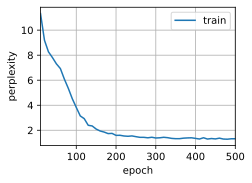

In [6]:
# RNN
rnn_layer = nn.RNN(len(vocab), num_hiddens)
model_RNN = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
model_RNN = model_RNN.to(device)
d2l.train_ch8(model_RNN, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 334053.0 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


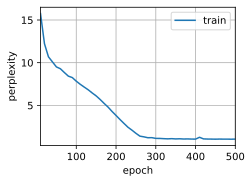

In [7]:
# GRU
gru_layer = nn.GRU(num_inputs, num_hiddens)
model_GRU = d2l.RNNModel(gru_layer, len(vocab))
model_GRU = model_GRU.to(device)
d2l.train_ch8(model_GRU, train_iter, vocab, lr, num_epochs, device)

perplexity 1.2, 273375.7 tokens/sec on cuda:0
time travelleryou can show black the vermalllerare thes haie bot
travelleryou can show black the preen time dmine all mas in


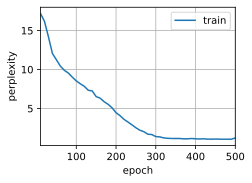

In [8]:
# LSTM
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model_lstm = d2l.RNNModel(lstm_layer, len(vocab))
model_lstm = model_lstm.to(device)
d2l.train_ch8(model_lstm, train_iter, vocab, lr, num_epochs, device) 

[参考答案](https://blog.csdn.net/qq_43941037/article/details/133920253)

## Deep-RNN

![深度循环神经网络结构](./img/deep-rnn.svg)

深度循环神经网络具有L个隐藏层，每个隐状态都连续地传递到当前层的下一个时间步和下一层的当前时间步。

假设在时间步$t$有一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数：$n$，每个样本中的输入数：$d$）。
同时，将$l^\mathrm{th}$隐藏层（$l=1,\ldots,L$）
的隐状态设为$\mathbf{H}_t^{(l)}  \in \mathbb{R}^{n \times h}$
（隐藏单元数：$h$），
输出层变量设为$\mathbf{O}_t \in \mathbb{R}^{n \times q}$
（输出数：$q$）。
设置$\mathbf{H}_t^{(0)} = \mathbf{X}_t$，
第$l$个隐藏层的隐状态使用激活函数$\phi_l$，则：

（1）

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}),$$

其中，权重$\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$，
$\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$和
偏置$\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$
都是第$l$个隐藏层的模型参数。

最后，输出层的计算仅基于第$l$个隐藏层最终的隐状态：

（2）

$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$都是输出层的模型参数。

与多层感知机一样，隐藏层数目$L$和隐藏单元数目$h$都是超参数。
也就是说，它们可以由我们调整的。
另外，用门控循环单元或长短期记忆网络的隐状态
来代替（1）式中的隐状态进行计算，
可以很容易地得到深度门控循环神经网络或深度长短期记忆神经网络。

In [2]:
import torch
from torch import nn
import re
import random
import collections
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [10]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

perplexity 1.0, 184112.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


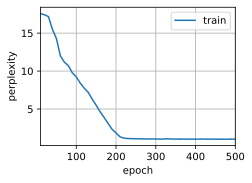

In [11]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

### Deep RNN from Scratch

perplexity 1.0, 68109.7 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


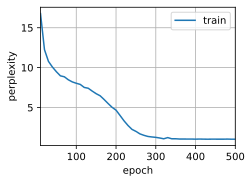

In [5]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

def get_params_bilayer(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层1参数
    W_xh1 = normal((num_inputs, num_hiddens))
    W_hh1 = normal((num_hiddens, num_hiddens))
    b_h1 = torch.zeros(num_hiddens, device=device)
    # 新增隐藏层2参数
    W_hh2 = normal((num_hiddens, num_hiddens))
    b_h2 = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh1, W_hh1, b_h1, W_hh2, b_h2, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state_bilayer(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))  # 新增第二个隐状态初始化张量

def rnn_bilayer(inputs, state, params):  # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh1, W_hh1, b_h1, W_hh2, b_h2, W_hq, b_q = params  # 新增第二层参数
    H1, H2 = state
    outputs = []
    for X in inputs:  # X的形状：(批量大小，词表大小) 前面转置是为了这里遍历
        H1 = torch.tanh(torch.mm(X, W_xh1) + torch.mm(H1, W_hh1) + b_h1)  # 计算隐状态1
        H2 = torch.tanh(torch.mm(H1, W_hh2) + b_h2)  # 计算隐状态2
        Y = torch.mm(H2, W_hq) + b_q  # 计算输出
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H1, H2)  # 沿时间步拼接

num_hiddens = 512
net_rnn_bilayer = d2l.RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params_bilayer,
                      init_rnn_state_bilayer, rnn_bilayer)
num_epochs, lr = 500, 1
d2l.train_ch8(net_rnn_bilayer, train_iter, vocab, lr, num_epochs, d2l.try_gpu())


### GRU Replaced

In [3]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.GRU(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

perplexity 1.0, 205288.7 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


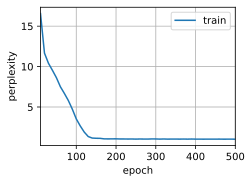

In [4]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

[参考答案](https://blog.csdn.net/qq_43941037/article/details/133931633)

## Bi-RNN

对于有$T$个观测值的序列，
我们在观测状态和隐状态上具有以下联合概率分布：

（1）

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1).$$

现在，假设我们观测到所有的$x_i$，除了$x_j$，
并且我们的目标是计算$P(x_j \mid x_{-j})$，
其中$x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$。
由于$P(x_j \mid x_{-j})$中没有隐变量，
因此我们考虑对$h_1, \ldots, h_T$选择构成的
所有可能的组合进行求和。
如果任何$h_i$可以接受$k$个不同的值（有限的状态数），
这意味着我们需要对$k^T$个项求和，
这个任务显然难于登天。
幸运的是，有个巧妙的解决方案：*动态规划*（dynamic programming）。

要了解动态规划的工作方式，
我们考虑对隐变量$h_1, \ldots, h_T$的依次求和。
根据（1）式将得出：

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

通常，我们将*前向递归*（forward recursion）写为：

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

递归被初始化为$\pi_1(h_1) = P(h_1)$。
符号简化，也可以写成$\pi_{t+1} 
= f(\pi_t, x_t)$，
其中$f$是一些可学习的函数。
这看起来就像我们在循环神经网络中讨论的隐变量模型中的更新方程。

与前向递归一样，我们也可以使用后向递归对同一组隐变量求和。这将得到：

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$

因此，我们可以将*后向递归*（backward recursion）写为：

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

初始化$\rho_T(h_T) = 1$。
前向和后向递归都允许我们对$T$个隐变量在$\mathcal{O}(kT)$
（线性而不是指数）时间内对$(h_1, \ldots, h_T)$的所有值求和。
这是使用图模型进行概率推理的巨大好处之一。
它也是通用消息传递算法的一个非常特殊的例子。
结合前向和后向递归，我们能够计算

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

因为符号简化的需要，后向递归也可以写为$\rho_{t-1} = g(\rho_t, x_t)$，
其中$g$是一个可以学习的函数。
同样，这看起来非常像一个更新方程，
只是不像我们在循环神经网络中看到的那样前向运算，而是后向计算。
事实上，知道未来数据何时可用对隐马尔可夫模型是有益的。
信号处理学家将是否知道未来观测这两种情况区分为内插和外推。


![双向循环神经网络架构](./img/birnn.svg)

对于任意时间步$t$，给定一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数$n$，每个示例中的输入数$d$），
并且令隐藏层激活函数为$\phi$。
在双向架构中，我们设该时间步的前向和反向隐状态分别为
$\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$和
$\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$，
其中$h$是隐藏单元的数目。
前向和反向隐状态的更新如下：

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

其中，权重$\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$
和偏置$\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}, \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$都是模型参数。

接下来，将前向隐状态$\overrightarrow{\mathbf{H}}_t$
和反向隐状态$\overleftarrow{\mathbf{H}}_t$连接起来，
获得需要送入输出层的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$。
在具有多个隐藏层的深度双向循环神经网络中，
该信息作为输入传递到下一个双向层。
最后，输出层计算得到的输出为
$\mathbf{O}_t \in \mathbb{R}^{n \times q}$（$q$是输出单元的数目）：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

这里，权重矩阵$\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$
和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$
是输出层的模型参数。
事实上，这两个方向可以拥有不同数量的隐藏单元。

双向循环神经网络的一个关键特性是：使用来自序列两端的信息来估计输出。
也就是说，我们使用来自过去和未来的观测信息来预测当前的观测。
但是在对下一个词元进行预测的情况中，这样的模型并不是我们所需的。
因为在预测下一个词元时，我们终究无法知道下一个词元的下文是什么，
所以将不会得到很好的精度。

另一个严重问题是，双向循环神经网络的计算速度非常慢。
其主要原因是网络的前向传播需要在双向层中进行前向和后向递归，
并且网络的反向传播还依赖于前向传播的结果。
因此，梯度求解将有一个非常长的链。

双向层的使用在实践中非常少，并且仅仅应用于部分场合。
例如，填充缺失的单词、词元注释（例如，用于命名实体识别）
以及作为序列处理流水线中的一个步骤对序列进行编码（例如，用于机器翻译）。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.1, 135588.1 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


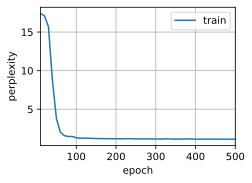

In [3]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr*1.0, 500, device)

[参考](https://blog.csdn.net/qq_43941037/article/details/133938312)

## Machine Translation

### Preprocess

In [4]:
import os
import torch
from d2l import torch as d2l

In [5]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """加载英法数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
              encoding='utf-8') as f:
        return f.read()
    

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [11]:
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [14]:
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target
    
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

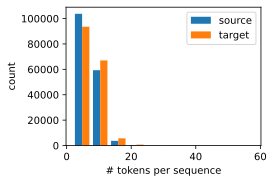

In [16]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]]
    )
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    # for patch in patches[1].patches:
        # patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target)

In [18]:
# <unk>:未知词元 <bos>:开始词元 <eos>:结束词元
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [19]:
# 截断 & 填充
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [23]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines
    ])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [21]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [24]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 10,  85,   4,   3,   1,   1,   1,   1],
        [  6, 147,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[8, 0, 4, 3, 1, 1, 1, 1],
        [6, 7, 0, 4, 3, 1, 1, 1]], dtype=torch.int32)
Y的有效长度: tensor([4, 5])


中文分词算法主要分为两大类：基于字典的分词算法和基于统计的分词算法。

1. 基于字典的分词算法
基于字典的分词算法是最简单、最直接的分词方法。它通过查找预定义的词典，将待分词的文本与词典中的词汇进行匹配，从而实现分词。这种方法的优点是实现简单、速度快，但缺点是对于词典中未收录的词汇或新词无法有效处理，容易出现分词错误。

2. 基于统计的分词算法
基于统计的分词算法则是利用统计学原理，通过训练大量语料库，学习汉字的组合规律，从而实现分词。这种方法能够处理词典中未收录的词汇和新词，具有更高的分词准确率和适应性。但缺点是计算量大、速度慢，需要消耗更多的计算资源。

三、分词算法的优缺点
1. 基于字典的分词算法
优点：实现简单、速度快、对常见词汇的分词效果好。

缺点：对于词典中未收录的词汇或新词无法有效处理，容易出现分词错误。

2. 基于统计的分词算法
优点：能够处理词典中未收录的词汇和新词，分词准确率高、适应性强。

缺点：计算量大、速度慢、需要消耗更多的计算资源。

[参考](https://blog.csdn.net/jerry_liufeng/article/details/121317136)

### Encoder & Decoder

In [1]:
from torch import nn

class Encoder(nn.Module):
    """编码器基本接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [2]:
class Decoder(nn.Module):
    """解码器基本接口"""
    def __init__(self, **kwargs):
        super(Decoder).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError

In [3]:
class EncoderDecoder(nn.Module):
    """两者的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

### Seq-To-Seq

In [1]:
import math
import torch
import collections
from torch import nn
from d2l import torch as d2l

考虑由一个序列组成的样本（批量大小是$1$）。
假设输入序列是$x_1, \ldots, x_T$，
其中$x_t$是输入文本序列中的第$t$个词元。
在时间步$t$，循环神经网络将词元$x_t$的输入特征向量
$\mathbf{x}_t$和$\mathbf{h} _{t-1}$（即上一时间步的隐状态）
转换为$\mathbf{h}_t$（即当前步的隐状态）。
使用一个函数$f$来描述循环神经网络的循环层所做的变换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

总之，编码器通过选定的函数$q$，
将所有时间步的隐状态转换为上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

现在，让我们**实现循环神经网络编码器**。
注意，我们使用了*嵌入层*（embedding layer）
来获得输入序列中每个词元的特征向量。
嵌入层的权重是一个矩阵，
其行数等于输入词表的大小（`vocab_size`），
其列数等于特征向量的维度（`embed_size`）。
对于任意输入词元的索引$i$，
嵌入层获取权重矩阵的第$i$行（从$0$开始）以返回其特征向量。
另外，本文选择了一个多层门控循环单元来实现编码器。

In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)
        
    def forward(self, X, *args):
        # 输出形状(batch_size, num_steps, embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()  # 设为评估模式
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [4]:
state.shape

torch.Size([2, 4, 16])

In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state


In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [7]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value  # 取反
    return X

# Test
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [10]:
# Test
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [11]:
# Train
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和, 词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f}, tokens/sec on {str(device)}')

loss 0.019, 26175.5, tokens/sec on cuda:0


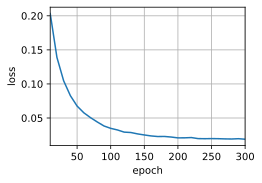

In [13]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [14]:
# Predict
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

### BLEU

原则上说，对于预测序列中的任意$n$元语法（n-grams），
BLEU的评估都是这个$n$元语法是否出现在标签序列中。

我们将BLEU定义为：

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$

其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和
$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，
$k$是用于匹配的最长的$n$元语法。
另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：
第一个是预测序列与标签序列中匹配的$n$元语法的数量，
第二个是预测序列中$n$元语法的数量的比率。
具体地说，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$、$B$、$C$、$D$，
我们有$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$和$p_4 = 0$。

根据上式中BLEU的定义，
当预测序列与标签序列完全相同时，BLEU为$1$。
此外，由于$n$元语法越长则匹配难度越大，
所以BLEU为更长的$n$元语法的精确度分配更大的权重。
具体来说，当$p_n$固定时，$p_n^{1/2^n}$
会随着$n$的增长而增加（原始论文使用$p_n^{1/n}$）。
而且，由于预测的序列越短获得的$p_n$值越高，
所以上式中乘法项之前的系数用于惩罚较短的预测序列。
例如，当$k=2$时，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$，尽管$p_1 = p_2 = 1$，
惩罚因子$\exp(1-6/2) \approx 0.14$会降低BLEU。

In [26]:
# Evaluation
def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [27]:
# Test
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


### Adjusting the hyperparameters

loss 0.019, 33268.0, tokens/sec on cuda:0


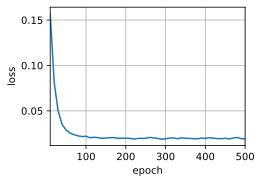

In [28]:
embed_size1, num_hiddens1, num_layers1, dropout1 = 64, 64, 2, 0.2
batch_size1, num_steps1 = 128, 10
lr1, num_epochs1, device1 = 0.01, 500, d2l.try_gpu()

train_iter1, src_vocab1, tgt_vocab1 = d2l.load_data_nmt(batch_size1, num_steps1)
encoder1 = Seq2SeqEncoder(len(src_vocab1), embed_size1, num_hiddens1, num_layers1,
                        dropout1)
decoder1 = Seq2SeqDecoder(len(tgt_vocab1), embed_size1, num_hiddens1, num_layers1,
                        dropout1)
net1 = d2l.EncoderDecoder(encoder1, decoder1)
train_seq2seq(net1, train_iter1, lr1, num_epochs1, tgt_vocab1, device1)

In [29]:
# Test
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net1, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est bon ?, bleu 0.537
i'm home . => je suis chez moi ., bleu 1.000


### No Hidden for `<pad>` & `<eos>`

loss 0.018, 26039.7 tokens/sec on cuda:0


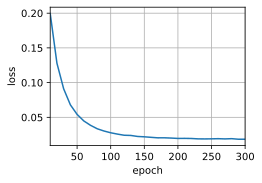

In [30]:
class MaskedSoftmaxCELoss_test(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        self.reduction='none'
        return super(MaskedSoftmaxCELoss_test, self).forward(
            pred.permute(0, 2, 1), label).mean(dim=1)  # 没有遮蔽

def train_seq2seq_test(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):  # xavier 初始化
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # 使用 Adam 优化器
    loss = MaskedSoftmaxCELoss_test()  # 使用改造的交叉熵损失
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 设置两个累加器：训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]  # 加载数据
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],  # 获取特定的开始词元
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学，拼接开始词元和原始输出序列
            Y_hat, _ = net(X, dec_input, X_valid_len)  # 前向传播
            l = loss(Y_hat, Y, Y_valid_len)  # 计算损失
            l.sum().backward()  # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)  # 梯度裁剪
            num_tokens = Y_valid_len.sum()
            optimizer.step()  # 优化
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')
    
embed_size2, num_hiddens2, num_layers2, dropout2 = 32, 32, 2, 0.1
batch_size2, num_steps2 = 64, 10
lr2, num_epochs2, device2 = 0.005, 300, d2l.try_gpu()

train_iter2, src_vocab2, tgt_vocab2 = d2l.load_data_nmt(batch_size2, num_steps2)
encoder2 = Seq2SeqEncoder(len(src_vocab2), embed_size2, num_hiddens2, num_layers2,
                        dropout2)
decoder2 = Seq2SeqDecoder(len(tgt_vocab2), embed_size2, num_hiddens2, num_layers2,
                        dropout2)
net2 = d2l.EncoderDecoder(encoder2, decoder2)
train_seq2seq_test(net2, train_iter2, lr2, num_epochs2, tgt_vocab, device2)

In [31]:
# Test
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net2, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai <unk> perdu perdu ., bleu 0.548
he's calm . => je vais bien ., bleu 0.000
i'm home . => je suis suis suis suis suis ., bleu 0.418


### LSTM replacement

In [39]:
class Seq2SeqEncoder1(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder1, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.lstm(X)
        return output, state
    
class Seq2SeqDecoder1(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder1, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        # context = state[-1].repeat(X.shape[0], 1, 1)
        context = state[-1][0].repeat(X.shape[0], 1, 1)  # # 注意 LSTM 有 hidden state 和 cell state，这里使用 hidden state
        X_and_context = torch.cat((X, context), 2)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.lstm(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [33]:
embed_size3, num_hiddens3, num_layers3, dropout3 = 32, 32, 2, 0.1
batch_size3, num_steps3 = 64, 10
lr3, num_epochs3, device3 = 0.005, 300, d2l.try_gpu()

loss 0.019, 24449.0, tokens/sec on cuda:0


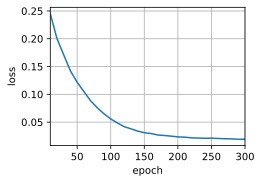

In [40]:
train_iter3, src_vocab3, tgt_vocab3 = d2l.load_data_nmt(batch_size3, num_steps3)
encoder3 = Seq2SeqEncoder1(len(src_vocab3), embed_size3, num_hiddens3, num_layers3,
                        dropout3)
decoder3 = Seq2SeqDecoder1(len(tgt_vocab3), embed_size3, num_hiddens3, num_layers3,
                        dropout3)
net3 = d2l.EncoderDecoder(encoder3, decoder3)
train_seq2seq(net3, train_iter3, lr3, num_epochs3, tgt_vocab3, device3)

In [41]:
# Test
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net3, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est porte porte, bleu 0.537
i'm home . => je suis <unk> <unk> en, bleu 0.447


[参考答案](https://blog.csdn.net/qq_43941037/article/details/133958279)

## Beam-Search

如果精度最重要，则显然是穷举搜索。
如果计算成本最重要，则显然是贪心搜索。
而束搜索的实际应用则介于这两个极端之间。

*束搜索*（beam search）是贪心搜索的一个改进版本。
它有一个超参数，名为*束宽*（beam size）$k$。
在时间步$1$，我们选择具有最高条件概率的$k$个词元。
这$k$个词元将分别是$k$个候选输出序列的第一个词元。
在随后的每个时间步，基于上一时间步的$k$个候选输出序列，
我们将继续从$k\left|\mathcal{Y}\right|$个可能的选择中
挑出具有最高条件概率的$k$个候选输出序列。

![束搜索过程（束宽：2，输出序列的最大长度：3）。候选输出序列是$A$、$C$、$AB$、$CE$、$ABD$和$CED$](./img/beam-search.svg)

假设输出的词表只包含五个元素：
$\mathcal{Y} = \{A, B, C, D, E\}$，
其中有一个是“&lt;eos&gt;”。
设置束宽为$2$，输出序列的最大长度为$3$。
在时间步$1$，假设具有最高条件概率
$P(y_1 \mid \mathbf{c})$的词元是$A$和$C$。
在时间步$2$，我们计算所有$y_2 \in \mathcal{Y}$为：

$$\begin{aligned}P(A, y_2 \mid \mathbf{c}) = P(A \mid \mathbf{c})P(y_2 \mid A, \mathbf{c}),\\ P(C, y_2 \mid \mathbf{c}) = P(C \mid \mathbf{c})P(y_2 \mid C, \mathbf{c}),\end{aligned}$$  

从这十个值中选择最大的两个，
比如$P(A, B \mid \mathbf{c})$和$P(C, E \mid \mathbf{c})$。
然后在时间步$3$，我们计算所有$y_3 \in \mathcal{Y}$为：

$$\begin{aligned}P(A, B, y_3 \mid \mathbf{c}) = P(A, B \mid \mathbf{c})P(y_3 \mid A, B, \mathbf{c}),\\P(C, E, y_3 \mid \mathbf{c}) = P(C, E \mid \mathbf{c})P(y_3 \mid C, E, \mathbf{c}),\end{aligned}$$ 

从这十个值中选择最大的两个，
即$P(A, B, D \mid \mathbf{c})$和$P(C, E, D \mid  \mathbf{c})$，
我们会得到六个候选输出序列：
（1）$A$；（2）$C$；（3）$A,B$；（4）$C,E$；（5）$A,B,D$；（6）$C,E,D$。

最后，基于这六个序列（例如，丢弃包括“&lt;eos&gt;”和之后的部分），
我们获得最终候选输出序列集合。
然后我们选择其中条件概率乘积最高的序列作为输出序列：

$$ \frac{1}{L^\alpha} \log P(y_1, \ldots, y_{L}\mid \mathbf{c}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}),$$

其中$L$是最终候选序列的长度，
$\alpha$通常设置为$0.75$。
因为一个较长的序列在上式
的求和中会有更多的对数项，
因此分母中的$L^\alpha$用于惩罚长序列。

束搜索的计算量为$\mathcal{O}(k\left|\mathcal{Y}\right|T')$，
这个结果介于贪心搜索和穷举搜索之间。
实际上，贪心搜索可以看作一种束宽为$1$的特殊类型的束搜索。
通过灵活地选择束宽，束搜索可以在正确率和计算代价之间进行权衡。